# **Tópicos Selectos en Aprendizaje Maquinal**

**Doctorado en Ingeniería: mención en Señales, Sistemas e Inteligencia Computacional**

**FICH - UNL -** **Instituto de investigación en Señales, Sistemas e Inteligencia Computacional**

<img src=http://sinc.unl.edu.ar/wp-content/themes/sinci/img/sinc-logo.png width="150">


Consultas: *Leandro Vignolo*
ldvignolo@sinc.unl.edu.ar

## **Trabajo práctico Nº 2: problemas de clasificación con datos reales**

**Modificar los parámetros correspondientes a cada método de clasificación y de validación cruzada, según se indica en la guía de TP disponible en http://tsam-fich.wikidot.com/apuntes**

**Para una referencia de los métodos y sus parámetros ver la documentación de sklearn en https://scikit-learn.org/**


---


***Guardar una copia personal de la Colab para trabajar en ella y guardar los cambios***


---




### **Carga de librerías**

In [1]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from collections import Counter
import numpy as np
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics.pairwise import rbf_kernel
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate
from warnings import simplefilter
import time
from sklearn.feature_selection import RFE
from sklearn.svm import LinearSVC
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

# instalar librería adicional para el método Relief
!pip install sklearn-relief
import sklearn_relief as relief

# Para una referencia detallada de los métodos empleados y los parámetros correspondientes ver la documentación de sklearn en https://scikit-learn.org/stable/index.html


### **Definiciones de clasificadores**
***Modificar los parámetros de cada método***


Naive Bayes

In [2]:
# 1 Naive Bayes
def clf_NB(X_train, X_test, y_train, y_test):

    classes = np.unique(y_train)
    nt = y_train.shape[0]
    props = []
    for i in range(0,len(classes)):
        props.append( np.sum(y_train==classes[i])/nt )

    bayes = GaussianNB(priors=props, var_smoothing=1e-09)
    # entrenamiento
    bayes.fit(X_train, y_train)
    # predicción sobre datos de prueba
    y_pred = bayes.predict(X_test)
    # cálculo de métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf

Perceptrón Multicapa

In [3]:
# 2 MLP
def clf_MLP(X_train, X_test, y_train, y_test):
    clf = MLPClassifier(hidden_layer_sizes = (5, 3),      # arquitectura de la red
                        activation = 'relu',              # función de activación
                        solver = 'adam',                  # algoritmo de optimización
                        learning_rate_init = 0.001,       # tasa de aprendizaje
                        max_iter = 300,                   # épocas de entrenamiento
                        tol = 0.0000001,                  # tolerancia de error
                        verbose = False)                  # mostrar salida durante entrenamiento
    # entrenamiento
    clf.fit(X_train, y_train)
    # predicción sobre datos de prueba
    y_pred = clf.predict(X_test)
    # cálculo de métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf

Red Nuronal con Funciones de Base Radial

In [4]:
# 3 RBF
def clf_RBF(X_train, X_test, y_train, y_test):

    # entreno centroides con Kmeans usando datos de train
    model = KMeans(n_clusters=8)                 # definir cantidad de centroides
    model.fit(X_train)

    sigma = np.ones(model.n_clusters)
    Z_train = np.empty([X_train.shape[0],model.n_clusters])
    Z_test  = np.empty([X_test.shape[0],model.n_clusters])
    # calculo salidas de la capa RBF (mapeo)
    for clus in range(0,model.n_clusters):
        # estimación de la STD media para cada clúster/centroide sobre datos de entrenamiento
        aux = X_train[model.labels_==clus]
        if len(aux)!=0:                                # si el centroide no quedó sin patrones
            sigma[clus] = np.mean(np.std(aux,axis=0))  # STD promedio sobre las dimensiones
        if (sigma[clus]==0):
            sigma[clus] = 1.0
        # obtengo la salida de cada RBF con datos de train y test
        # las salidas las RBF son las nuevas features y las guardo en las columnas de los array para train y test
        Z_train[:,clus] = rbf_kernel([model.cluster_centers_[clus]], X_train, gamma=1.0/(sigma[clus]**2)).reshape(X_train.shape[0])
        Z_test[:,clus]  = rbf_kernel([model.cluster_centers_[clus]], X_test,  gamma=1.0/(sigma[clus]**2)).reshape(X_test.shape[0])

    # defino y entreno la capa de salida
    clf = Perceptron(tol=1e-3, random_state=0)   # definir tolerancia de error
    clf.fit(Z_train, y_train)
    # obtengo las predicciones de la capa de salida para los datos de prueba
    y_pred = clf.predict(Z_test)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf

Árbol de Decisión

In [5]:
## 4 Árbol de decisión
def clf_TREE(X_train, X_test, y_train, y_test):
    dtree = DecisionTreeClassifier(random_state=0, max_depth=2) # definición y seteo de parámetros del clasificador
    # entrenamiento
    dtree.fit(X_train, y_train)
    # prueba
    y_pred = dtree.predict(X_test)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf

Random Forest

In [6]:
## 5 RandomForest
def clf_RF(X_train, X_test, y_train, y_test):
    clf = RandomForestClassifier(max_depth=None, random_state=0, n_estimators=100) # parámetros del clasificador RandomForest
    # entrenamiento
    clf.fit(X_train, y_train)
    # prueba
    y_pred = clf.predict(X_test)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf

Máquina de Soporte Vectorial

In [7]:
## 6 SVM
def clf_SVM(X_train, X_test, y_train, y_test):
    #clf = svm.SVC(kernel='linear')                               # SVM Kernel Lineal
    clf = svm.SVC(kernel='poly', degree=2, coef0=1, gamma='auto') # SVM Kernel polinomial
    #clf = svm.SVC(kernel='rbf',gamma=1)                          # SVM Kernel RBF
    # Entrenamiento
    clf.fit(X_train, y_train)
    # Predicción sobre datos de prueba
    y_pred = clf.predict(X_test)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf

Método de Selección de Características y Máquina de Soporte Vectorial

In [8]:
## 7 FEATURE SELECTION + SVM
def clf_FS_SVM(X_train, X_test, y_train, y_test):

    # defino el método de ranking con criterio de ANOVA F (f_classif)
    FS = SelectKBest(f_classif, k=2)        # definir cuántas características se desean seleccionar
    # realizo la selección en base a datos de train
    FS = FS.fit(X_train, y_train)
    # mapeo / aplico la selección en train y test
    X_train_new = FS.transform(X_train)
    X_test_new  = FS.transform(X_test)
    # defino clasificador SVM
    clf = svm.SVC(kernel='rbf', gamma=1) # Kernel RBF
    # entreno el clasificador
    clf.fit(X_train_new, y_train)
    # predicción en datos de prueba
    y_pred = clf.predict(X_test_new)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train_new.shape[1]
    return acc, uar, rec, nf

Autoencoder y Máquina de Soporte Vectorial

In [9]:
## 8 Autoencoder + SVM

def clf_AE_SVM(X_train, X_test, y_train, y_test, plot=False, ax1=None, ax2=None):


    n_input = len(X_train[0])
    # Estructura del codificador
    n_encoder1 = 500
    n_encoder2 = 300
    n_latent = 2
    # Estructura del decodificador
    n_decoder2 = 300
    n_decoder1 = 500
    # definición del Autoencoder
    AE = MLPRegressor(hidden_layer_sizes = (n_encoder1, n_encoder2, n_latent, n_decoder2, n_decoder1),
                      activation = 'tanh',
                      solver = 'adam',
                      learning_rate_init = 0.0001,
                      max_iter = 300,
                      tol = 0.0000001,
                      verbose = False)

    # Entrenamiento del autoencoder
    AE.fit(X_train, X_train)

    # defino función para obtener representación latente
    def encoder(data):
        data = np.asmatrix(data)
        encoder1 = data*AE.coefs_[0] + AE.intercepts_[0]
        encoder1 = (np.exp(encoder1) - np.exp(-encoder1))/(np.exp(encoder1) + np.exp(-encoder1))
        encoder2 = encoder1*AE.coefs_[1] + AE.intercepts_[1]
        encoder2 = (np.exp(encoder2) - np.exp(-encoder2))/(np.exp(encoder2) + np.exp(-encoder2))
        latent = encoder2*AE.coefs_[2] + AE.intercepts_[2]
        latent = (np.exp(latent) - np.exp(-latent))/(np.exp(latent) + np.exp(-latent))
        return np.asarray(latent)

    # mapeo train / test
    train_latent = encoder(X_train)
    test_latent = encoder(X_test)

    if plot:
        ax1.scatter(train_latent[:,0], train_latent[:,1], s=50, c=y_train, marker="o")
        ax1.set_xlabel("Latent1")
        ax1.set_ylabel("Latent2")
        ax1.set_title("Train Data")
        ax2.scatter(test_latent[:,0],  test_latent[:,1],  s=50, c=y_test, marker="o")
        ax2.set_xlabel("Latent1")
        ax2.set_ylabel("Latent2")
        ax2.set_title("Test Data")

    # entrenamiento de un SVM empleando la representación latente
    #clf = svm.SVC(kernel='linear') # SVM Kernel lineal
    clf = svm.SVC(kernel='poly', degree=2, coef0=1, gamma='auto') # SVM kernel polinomial
    #clf = svm.SVC(kernel='rbf',gamma=1) # SVM Kernel RBF
    clf.fit(train_latent, y_train)
    y_pred = clf.predict(test_latent)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = train_latent.shape[1]
    return acc, uar, rec, nf

k-Medias

In [10]:
## 9 k-means
def clf_kMeans(X_train, X_test, y_train, y_test):
    # entreno el algoritmo de clustering
    model = KMeans(n_clusters=8)
    model.fit(X_train)

    # defino vector para asignar las etiquetas a los datos de entrenamiento
    train_Labels = np.empty(len(X_train))
    # defino vector para asignar una etiqueta de clase a cada clúster
    cluster_labels = np.empty(model.n_clusters)
    # para cada clúster
    for clus in range(0,model.n_clusters):
        # model.labels_ indica el clúster al que pertenece cada patrón
        original_labels = y_train[model.labels_==clus]
        # original_labels contiene las etiquetas de los elementos del clúster
        count = Counter(original_labels)
        # asigno etiqueta de clase a cada clúster
        cluster_labels[clus] = max(count, key=count.get)
        # asigno etiqueta de clase a cada patrón de train en ese clúster
        train_Labels[model.labels_==clus] = cluster_labels[clus]

    # obtengo un clúster para cada dato de test
    clus_test_pred = model.predict(X_test)
    # obtengo etiqueta para cada dato de test
    y_pred = cluster_labels[clus_test_pred]
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf

### **Ejercicio 1: dataset "Diabetes"**


In [11]:
def clf_NB_conf1(X_train, X_test, y_train, y_test):
    bayes = GaussianNB(priors=None, var_smoothing=1e-09)
    # entrenamiento
    bayes.fit(X_train, y_train)
    # predicción sobre datos de prueba
    y_pred = bayes.predict(X_test)
    # cálculo de métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf

def clf_NB_conf2(X_train, X_test, y_train, y_test):
    bayes = GaussianNB(priors=None, var_smoothing=1e-05)
    # entrenamiento
    bayes.fit(X_train, y_train)
    # predicción sobre datos de prueba
    y_pred = bayes.predict(X_test)
    # cálculo de métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf

In [26]:
def clf_MLP1(X_train, X_test, y_train, y_test):
    clf = MLPClassifier(hidden_layer_sizes=(8,4),
                         activation='relu',
                         solver='adam',
                         learning_rate_init=0.001,
                         max_iter=300)               # mostrar salida durante entrenamiento
    # entrenamiento
    clf.fit(X_train, y_train)
    # predicción sobre datos de prueba
    y_pred = clf.predict(X_test)
    # cálculo de métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf

def clf_MLP2(X_train, X_test, y_train, y_test):
    clf = MLPClassifier(hidden_layer_sizes=(16,16),
                         activation='tanh',
                         solver='sgd',
                         learning_rate_init=0.01,
                         max_iter=500)              # mostrar salida durante entrenamiento
    # entrenamiento
    clf.fit(X_train, y_train)
    # predicción sobre datos de prueba
    y_pred = clf.predict(X_test)
    # cálculo de métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf

In [29]:
# 3 RBF
def clf_RBF1(X_train, X_test, y_train, y_test):

    # entreno centroides con Kmeans usando datos de train
    model = KMeans(n_clusters=8)                 # definir cantidad de centroides
    model.fit(X_train)

    sigma = np.ones(model.n_clusters)
    Z_train = np.empty([X_train.shape[0],model.n_clusters])
    Z_test  = np.empty([X_test.shape[0],model.n_clusters])
    # calculo salidas de la capa RBF (mapeo)
    for clus in range(0,model.n_clusters):
        # estimación de la STD media para cada clúster/centroide sobre datos de entrenamiento
        aux = X_train[model.labels_==clus]
        if len(aux)!=0:                                # si el centroide no quedó sin patrones
            sigma[clus] = np.mean(np.std(aux,axis=0))  # STD promedio sobre las dimensiones
        if (sigma[clus]==0):
            sigma[clus] = 1.0
        # obtengo la salida de cada RBF con datos de train y test
        # las salidas las RBF son las nuevas features y las guardo en las columnas de los array para train y test
        Z_train[:,clus] = rbf_kernel([model.cluster_centers_[clus]], X_train, gamma=1.0/(sigma[clus]**2)).reshape(X_train.shape[0])
        Z_test[:,clus]  = rbf_kernel([model.cluster_centers_[clus]], X_test,  gamma=1.0/(sigma[clus]**2)).reshape(X_test.shape[0])

    # defino y entreno la capa de salida
    clf = Perceptron(tol=1e-3, random_state=0)   # definir tolerancia de error
    clf.fit(Z_train, y_train)
    # obtengo las predicciones de la capa de salida para los datos de prueba
    y_pred = clf.predict(Z_test)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf


# 3 RBF
def clf_RBF2(X_train, X_test, y_train, y_test):

    # entreno centroides con Kmeans usando datos de train
    model = KMeans(n_clusters=16)                 # definir cantidad de centroides
    model.fit(X_train)

    sigma = np.ones(model.n_clusters)
    Z_train = np.empty([X_train.shape[0],model.n_clusters])
    Z_test  = np.empty([X_test.shape[0],model.n_clusters])
    # calculo salidas de la capa RBF (mapeo)
    for clus in range(0,model.n_clusters):
        # estimación de la STD media para cada clúster/centroide sobre datos de entrenamiento
        aux = X_train[model.labels_==clus]
        if len(aux)!=0:                                # si el centroide no quedó sin patrones
            sigma[clus] = np.mean(np.std(aux,axis=0))  # STD promedio sobre las dimensiones
        if (sigma[clus]==0):
            sigma[clus] = 1.0
        # obtengo la salida de cada RBF con datos de train y test
        # las salidas las RBF son las nuevas features y las guardo en las columnas de los array para train y test
        Z_train[:,clus] = rbf_kernel([model.cluster_centers_[clus]], X_train, gamma=1.0/(sigma[clus]**2)).reshape(X_train.shape[0])
        Z_test[:,clus]  = rbf_kernel([model.cluster_centers_[clus]], X_test,  gamma=1.0/(sigma[clus]**2)).reshape(X_test.shape[0])

    # defino y entreno la capa de salida
    clf = Perceptron(tol=1e-3, random_state=0)   # definir tolerancia de error
    clf.fit(Z_train, y_train)
    # obtengo las predicciones de la capa de salida para los datos de prueba
    y_pred = clf.predict(Z_test)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf

In [32]:
## 4 Árbol de decisión
def clf_TREE1(X_train, X_test, y_train, y_test):
    dtree = DecisionTreeClassifier(random_state=0, max_depth=2, criterion='gini') # definición y seteo de parámetros del clasificador
    # entrenamiento
    dtree.fit(X_train, y_train)
    # prueba
    y_pred = dtree.predict(X_test)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf

## 4 Árbol de decisión
def clf_TREE2(X_train, X_test, y_train, y_test):
    dtree = DecisionTreeClassifier(max_depth=None, criterion='entropy', 
                                min_samples_split=5, min_samples_leaf=2) # definición y seteo de parámetros del clasificador
    # entrenamiento
    dtree.fit(X_train, y_train)
    # prueba
    y_pred = dtree.predict(X_test)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf

In [35]:
## 5 RandomForest
def clf_RF1(X_train, X_test, y_train, y_test):
    clf = RandomForestClassifier(max_depth=None, random_state=0, n_estimators=100) # parámetros del clasificador RandomForest
    # entrenamiento
    clf.fit(X_train, y_train)
    # prueba
    y_pred = clf.predict(X_test)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf

## 5 RandomForest
def clf_RF2(X_train, X_test, y_train, y_test):
    clf = RandomForestClassifier(max_depth=5, criterion='entropy', random_state=0, n_estimators=300) # parámetros del clasificador RandomForest
    # entrenamiento
    clf.fit(X_train, y_train)
    # prueba
    y_pred = clf.predict(X_test)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf

In [38]:
## 6 SVM
def clf_SVM1(X_train, X_test, y_train, y_test):
    #clf = svm.SVC(kernel='linear')                               # SVM Kernel Lineal
    clf = svm.SVC(kernel='poly', degree=2, coef0=1, gamma='auto') # SVM Kernel polinomial
    #clf = svm.SVC(kernel='rbf',gamma=1)                          # SVM Kernel RBF
    # Entrenamiento
    clf.fit(X_train, y_train)
    # Predicción sobre datos de prueba
    y_pred = clf.predict(X_test)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf

## 6 SVM
def clf_SVM2(X_train, X_test, y_train, y_test):
    #clf = svm.SVC(kernel='linear')                               # SVM Kernel Lineal
    #clf = svm.SVC(kernel='poly', degree=2, coef0=1, gamma='auto') # SVM Kernel polinomial
    clf = svm.SVC(kernel='rbf',gamma=0.01, C=10)                          # SVM Kernel RBF
    # Entrenamiento
    clf.fit(X_train, y_train)
    # Predicción sobre datos de prueba
    y_pred = clf.predict(X_test)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf

In [41]:
## 7 FEATURE SELECTION + SVM
def clf_FS_SVM1(X_train, X_test, y_train, y_test):

    # defino el método de ranking con criterio de ANOVA F (f_classif)
    FS = SelectKBest(f_classif, k=3)        # definir cuántas características se desean seleccionar
    # realizo la selección en base a datos de train
    FS = FS.fit(X_train, y_train)
    # mapeo / aplico la selección en train y test
    X_train_new = FS.transform(X_train)
    X_test_new  = FS.transform(X_test)
    # defino clasificador SVM
    clf = svm.SVC(kernel='linear', C=1.0) # Kernel RBF
    # entreno el clasificador
    clf.fit(X_train_new, y_train)
    # predicción en datos de prueba
    y_pred = clf.predict(X_test_new)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train_new.shape[1]
    return acc, uar, rec, nf

## 7 FEATURE SELECTION + SVM
def clf_FS_SVM2(X_train, X_test, y_train, y_test):

    # defino el método de ranking con criterio de ANOVA F (f_classif)
    FS = SelectKBest(f_classif, k=5)        # definir cuántas características se desean seleccionar
    # realizo la selección en base a datos de train
    FS = FS.fit(X_train, y_train)
    # mapeo / aplico la selección en train y test
    X_train_new = FS.transform(X_train)
    X_test_new  = FS.transform(X_test)
    # defino clasificador SVM
    clf = svm.SVC(kernel='rbf', gamma=0.1, C=10) # Kernel RBF
    # entreno el clasificador
    clf.fit(X_train_new, y_train)
    # predicción en datos de prueba
    y_pred = clf.predict(X_test_new)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train_new.shape[1]
    return acc, uar, rec, nf

In [45]:
## 8 Autoencoder + SVM

def clf_AE_SVM1(X_train, X_test, y_train, y_test, plot=False, ax1=None, ax2=None):


    n_input = len(X_train[0])
    # Estructura del codificador
    n_encoder1 = 500
    n_encoder2 = 300
    n_latent = 2
    # Estructura del decodificador
    n_decoder2 = 300
    n_decoder1 = 500
    # definición del Autoencoder
    AE = MLPRegressor(hidden_layer_sizes = (n_encoder1, n_encoder2, n_latent, n_decoder2, n_decoder1),
                      activation = 'tanh',
                      solver = 'adam',
                      learning_rate_init = 0.0001,
                      max_iter = 300,
                      tol = 0.0000001,
                      verbose = False)

    # Entrenamiento del autoencoder
    AE.fit(X_train, X_train)

    # defino función para obtener representación latente
    def encoder(data):
        data = np.asmatrix(data)
        encoder1 = data*AE.coefs_[0] + AE.intercepts_[0]
        encoder1 = (np.exp(encoder1) - np.exp(-encoder1))/(np.exp(encoder1) + np.exp(-encoder1))
        encoder2 = encoder1*AE.coefs_[1] + AE.intercepts_[1]
        encoder2 = (np.exp(encoder2) - np.exp(-encoder2))/(np.exp(encoder2) + np.exp(-encoder2))
        latent = encoder2*AE.coefs_[2] + AE.intercepts_[2]
        latent = (np.exp(latent) - np.exp(-latent))/(np.exp(latent) + np.exp(-latent))
        return np.asarray(latent)

    # mapeo train / test
    train_latent = encoder(X_train)
    test_latent = encoder(X_test)

    if plot:
        ax1.scatter(train_latent[:,0], train_latent[:,1], s=50, c=y_train, marker="o")
        ax1.set_xlabel("Latent1")
        ax1.set_ylabel("Latent2")
        ax1.set_title("Train Data")
        ax2.scatter(test_latent[:,0],  test_latent[:,1],  s=50, c=y_test, marker="o")
        ax2.set_xlabel("Latent1")
        ax2.set_ylabel("Latent2")
        ax2.set_title("Test Data")

    # entrenamiento de un SVM empleando la representación latente
    #clf = svm.SVC(kernel='linear') # SVM Kernel lineal
    clf = svm.SVC(kernel='poly', degree=2, coef0=1, gamma='auto') # SVM kernel polinomial
    #clf = svm.SVC(kernel='rbf',gamma=1) # SVM Kernel RBF
    clf.fit(train_latent, y_train)
    y_pred = clf.predict(test_latent)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = train_latent.shape[1]
    return acc, uar, rec, nf


## 8 Autoencoder + SVM

def clf_AE_SVM2(X_train, X_test, y_train, y_test, plot=False, ax1=None, ax2=None):


    n_input = len(X_train[0])
    # Estructura del codificador
    n_encoder1 = 500
    n_encoder2 = 300
    n_latent = 5
    # Estructura del decodificador
    n_decoder2 = 300
    n_decoder1 = 500
    # definición del Autoencoder
    AE = MLPRegressor(hidden_layer_sizes = (n_encoder1, n_encoder2, n_latent, n_decoder2, n_decoder1),
                      activation = 'relu',
                      solver = 'adam',
                      learning_rate_init = 0.0001,
                      max_iter = 300,
                      tol = 0.0000001,
                      verbose = False)

    # Entrenamiento del autoencoder
    AE.fit(X_train, X_train)

    # defino función para obtener representación latente
    def encoder(data):
        data = np.asmatrix(data)
        encoder1 = data*AE.coefs_[0] + AE.intercepts_[0]
        encoder1 = (np.exp(encoder1) - np.exp(-encoder1))/(np.exp(encoder1) + np.exp(-encoder1))
        encoder2 = encoder1*AE.coefs_[1] + AE.intercepts_[1]
        encoder2 = (np.exp(encoder2) - np.exp(-encoder2))/(np.exp(encoder2) + np.exp(-encoder2))
        latent = encoder2*AE.coefs_[2] + AE.intercepts_[2]
        latent = (np.exp(latent) - np.exp(-latent))/(np.exp(latent) + np.exp(-latent))
        return np.asarray(latent)

    # mapeo train / test
    train_latent = encoder(X_train)
    test_latent = encoder(X_test)

    if plot:
        ax1.scatter(train_latent[:,0], train_latent[:,1], s=50, c=y_train, marker="o")
        ax1.set_xlabel("Latent1")
        ax1.set_ylabel("Latent2")
        ax1.set_title("Train Data")
        ax2.scatter(test_latent[:,0],  test_latent[:,1],  s=50, c=y_test, marker="o")
        ax2.set_xlabel("Latent1")
        ax2.set_ylabel("Latent2")
        ax2.set_title("Test Data")

    # entrenamiento de un SVM empleando la representación latente
    #clf = svm.SVC(kernel='linear') # SVM Kernel lineal
    clf = svm.SVC(kernel='poly', degree=2, coef0=1, gamma='auto') # SVM kernel polinomial
    #clf = svm.SVC(kernel='rbf',gamma=1) # SVM Kernel RBF
    clf.fit(train_latent, y_train)
    y_pred = clf.predict(test_latent)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = train_latent.shape[1]
    return acc, uar, rec, nf

In [48]:
## 9 k-means
def clf_kMeans1(X_train, X_test, y_train, y_test):
    # entreno el algoritmo de clustering
    model = KMeans(n_clusters=8)
    model.fit(X_train)

    # defino vector para asignar las etiquetas a los datos de entrenamiento
    train_Labels = np.empty(len(X_train))
    # defino vector para asignar una etiqueta de clase a cada clúster
    cluster_labels = np.empty(model.n_clusters)
    # para cada clúster
    for clus in range(0,model.n_clusters):
        # model.labels_ indica el clúster al que pertenece cada patrón
        original_labels = y_train[model.labels_==clus]
        # original_labels contiene las etiquetas de los elementos del clúster
        count = Counter(original_labels)
        # asigno etiqueta de clase a cada clúster
        cluster_labels[clus] = max(count, key=count.get)
        # asigno etiqueta de clase a cada patrón de train en ese clúster
        train_Labels[model.labels_==clus] = cluster_labels[clus]

    # obtengo un clúster para cada dato de test
    clus_test_pred = model.predict(X_test)
    # obtengo etiqueta para cada dato de test
    y_pred = cluster_labels[clus_test_pred]
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf


## 9 k-means
def clf_kMeans2(X_train, X_test, y_train, y_test):
    # entreno el algoritmo de clustering
    model = KMeans(n_clusters=4)
    model.fit(X_train)

    # defino vector para asignar las etiquetas a los datos de entrenamiento
    train_Labels = np.empty(len(X_train))
    # defino vector para asignar una etiqueta de clase a cada clúster
    cluster_labels = np.empty(model.n_clusters)
    # para cada clúster
    for clus in range(0,model.n_clusters):
        # model.labels_ indica el clúster al que pertenece cada patrón
        original_labels = y_train[model.labels_==clus]
        # original_labels contiene las etiquetas de los elementos del clúster
        count = Counter(original_labels)
        # asigno etiqueta de clase a cada clúster
        cluster_labels[clus] = max(count, key=count.get)
        # asigno etiqueta de clase a cada patrón de train en ese clúster
        train_Labels[model.labels_==clus] = cluster_labels[clus]

    # obtengo un clúster para cada dato de test
    clus_test_pred = model.predict(X_test)
    # obtengo etiqueta para cada dato de test
    y_pred = cluster_labels[clus_test_pred]
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf

In [49]:
# defino lista de clasificadores
classifiers = ["clf_NB_conf1","clf_NB_conf2","clf_MLP1","clf_MLP2","clf_RBF1","clf_RBF2","clf_TREE1","clf_TREE2","clf_RF1","clf_RF2","clf_SVM1","clf_SVM2","clf_FS_SVM1","clf_FS_SVM2","clf_AE_SVM1","clf_AE_SVM2","clf_kMeans1","clf_kMeans2"]

# carga de datos
data = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv', header=None)
# separo patrones en X y etiquetas en Y
X = np.array(data)[:,0:8]
Y = np.array(data)[:,8]
# aleatorización de los datos
X, Y = shuffle(X, Y, random_state=0)

**Validación cruzada: particionado simple train/test**


Para test_size = 0.3

In [50]:
# validación cruzada: partición train/test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0, shuffle=True, stratify=Y)

# Estandarización de los datos
scaler = StandardScaler()
# Ajuste sobre de train
scaler.fit(X_train)
# transformación de datos train y test
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
vacc = []
vuar = []
vrec = []
vnf  = []
# llamada a cada clasificador con el fold actual
for clf in range(0,len(classifiers)):
    acc, uar, rec, nf = locals()[classifiers[clf]](X_train, X_test, y_train, y_test)
    # guardo las medidas de desempeño en un vector
    vacc.append(acc)
    vuar.append(uar)
    vrec.append(rec)
    vnf.append(nf)

# imprimo una tabla con los resultados
print(':::                      Simple CV                       :::')
table = [["Clasificador","ACC", "UAR", "Recall", "# Features"]]
for clf in range(0,len(classifiers)):
    table.append([ classifiers[clf][4:], '%.4f' % vacc[clf], '%.4f' % vuar[clf], '%.4f' % vrec[clf], '%1.1f' % vnf[clf] ])
print(tabulate(table, tablefmt="fancy_grid", showindex="always",stralign="center"))

/home/diego/anaconda3/envs/santiago_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/diego/anaconda3/envs/santiago_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


:::                      Simple CV                       :::
╒════╤══════════════╤════════╤════════╤════════╤════════════╕
│  0 │ Clasificador │  ACC   │  UAR   │ Recall │ # Features │
├────┼──────────────┼────────┼────────┼────────┼────────────┤
│  1 │   NB_conf1   │ 0.7273 │ 0.6849 │ 0.5432 │    8.0     │
├────┼──────────────┼────────┼────────┼────────┼────────────┤
│  2 │   NB_conf2   │ 0.7273 │ 0.6849 │ 0.5432 │    8.0     │
├────┼──────────────┼────────┼────────┼────────┼────────────┤
│  3 │     MLP1     │ 0.7619 │ 0.7230 │ 0.5926 │    8.0     │
├────┼──────────────┼────────┼────────┼────────┼────────────┤
│  4 │     MLP2     │ 0.7619 │ 0.7144 │ 0.5556 │    8.0     │
├────┼──────────────┼────────┼────────┼────────┼────────────┤
│  5 │     RBF1     │ 0.6494 │ 0.5000 │ 0.0000 │    8.0     │
├────┼──────────────┼────────┼────────┼────────┼────────────┤
│  6 │     RBF2     │ 0.6190 │ 0.5931 │ 0.5062 │    8.0     │
├────┼──────────────┼────────┼────────┼────────┼────────────┤
│  7 │   

/home/diego/anaconda3/envs/santiago_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/diego/anaconda3/envs/santiago_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Para test_size = 0.2

In [51]:
# validación cruzada: partición train/test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0, shuffle=True, stratify=Y)

# Estandarización de los datos
scaler = StandardScaler()
# Ajuste sobre de train
scaler.fit(X_train)
# transformación de datos train y test
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
vacc = []
vuar = []
vrec = []
vnf  = []
# llamada a cada clasificador con el fold actual
for clf in range(0,len(classifiers)):
    acc, uar, rec, nf = locals()[classifiers[clf]](X_train, X_test, y_train, y_test)
    # guardo las medidas de desempeño en un vector
    vacc.append(acc)
    vuar.append(uar)
    vrec.append(rec)
    vnf.append(nf)

# imprimo una tabla con los resultados
print(':::                      Simple CV                       :::')
table = [["Clasificador","ACC", "UAR", "Recall", "# Features"]]
for clf in range(0,len(classifiers)):
    table.append([ classifiers[clf][4:], '%.4f' % vacc[clf], '%.4f' % vuar[clf], '%.4f' % vrec[clf], '%1.1f' % vnf[clf] ])
print(tabulate(table, tablefmt="fancy_grid", showindex="always",stralign="center"))

/home/diego/anaconda3/envs/santiago_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/diego/anaconda3/envs/santiago_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


:::                      Simple CV                       :::
╒════╤══════════════╤════════╤════════╤════════╤════════════╕
│  0 │ Clasificador │  ACC   │  UAR   │ Recall │ # Features │
├────┼──────────────┼────────┼────────┼────────┼────────────┤
│  1 │   NB_conf1   │ 0.7338 │ 0.6885 │ 0.5370 │    8.0     │
├────┼──────────────┼────────┼────────┼────────┼────────────┤
│  2 │   NB_conf2   │ 0.7338 │ 0.6885 │ 0.5370 │    8.0     │
├────┼──────────────┼────────┼────────┼────────┼────────────┤
│  3 │     MLP1     │ 0.7468 │ 0.7028 │ 0.5556 │    8.0     │
├────┼──────────────┼────────┼────────┼────────┼────────────┤
│  4 │     MLP2     │ 0.7662 │ 0.7263 │ 0.5926 │    8.0     │
├────┼──────────────┼────────┼────────┼────────┼────────────┤
│  5 │     RBF1     │ 0.6494 │ 0.5000 │ 0.0000 │    8.0     │
├────┼──────────────┼────────┼────────┼────────┼────────────┤
│  6 │     RBF2     │ 0.6494 │ 0.6320 │ 0.5741 │    8.0     │
├────┼──────────────┼────────┼────────┼────────┼────────────┤
│  7 │   

/home/diego/anaconda3/envs/santiago_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/diego/anaconda3/envs/santiago_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


**K-Fold Cross Validation**

para 4 folds queda:

In [52]:
NFfolds = 4   #  Modificar, siempre >=2

# inicializo estructuras para guardar resultados
Macc = [[] for i in range(len(classifiers))]
Muar = [[] for i in range(len(classifiers))]
Mrec = [[] for i in range(len(classifiers))]
Mnf  = [[] for i in range(len(classifiers))]

# Validación cruzada K-Fold (estratificada / no estratificada)

kf = KFold(n_splits=NFfolds)                            # KFold no estratificado
# kf = StratifiedKFold(n_splits=NFfolds)                # KFold estratificado

for train_index, test_index in kf.split(X):

    # asigno datos y etiquetas segun los índices del fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    # Estandarización de los datos (sobre cada fold)
    scaler = StandardScaler()
    # Ajuste sobre de train
    scaler.fit(X_train)
    # transformación de datos train y test
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # llamada a cada clasificador con el fold actual
    for clf in range(0,len(classifiers)):
        acc, uar, rec, nf = locals()[classifiers[clf]](X_train, X_test, y_train, y_test)
        # guardo las medidas de desempeño en un vector
        Macc[clf].append(acc)
        Muar[clf].append(uar)
        Mrec[clf].append(rec)
        Mnf[clf].append(nf)

# convierto a array
Macc = np.array(Macc)
Muar = np.array(Muar)
Mrec = np.array(Mrec)
Mnf =  np.array(Mnf)
# cálculo de estadísticas
acc_mean = np.mean(Macc,axis=1)
uar_mean = np.mean(Muar,axis=1)
rec_mean = np.mean(Mrec,axis=1)
nf_mean  = np.mean(Mnf,axis=1)
acc_std = np.std(Macc,axis=1)
uar_std = np.std(Muar,axis=1)
rec_std = np.std(Mrec,axis=1)

# imprimo una tabla con los resultados
print(':::                                         k-Ffold CV                                             :::')
table = [["Clasificador","ACC Mean","ACC STD","UAR Mean","UAR STD", "Recall Mean","Recall STD", "# Features"]]
for clf in range(0,len(classifiers)):
    table.append([classifiers[clf][4:], '%.4f' % acc_mean[clf], '%.4f' % acc_std[clf], '%.4f' % uar_mean[clf], '%.4f' % uar_std[clf], '%.4f' % rec_mean[clf], '%.4f' % rec_std[clf], '%1.1f' % nf_mean[clf]])
print(tabulate(table, tablefmt="fancy_grid", showindex="always",stralign="center"))

/home/diego/anaconda3/envs/santiago_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/diego/anaconda3/envs/santiago_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/diego/anaconda3/envs/santiago_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/diego/anaconda3/envs/santiago_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1

:::                                         k-Ffold CV                                             :::
╒════╤══════════════╤══════════╤═════════╤══════════╤═════════╤═════════════╤════════════╤════════════╕
│  0 │ Clasificador │ ACC Mean │ ACC STD │ UAR Mean │ UAR STD │ Recall Mean │ Recall STD │ # Features │
├────┼──────────────┼──────────┼─────────┼──────────┼─────────┼─────────────┼────────────┼────────────┤
│  1 │   NB_conf1   │  0.7487  │ 0.0382  │  0.7081  │ 0.0421  │   0.5759    │   0.0629   │    8.0     │
├────┼──────────────┼──────────┼─────────┼──────────┼─────────┼─────────────┼────────────┼────────────┤
│  2 │   NB_conf2   │  0.7487  │ 0.0382  │  0.7081  │ 0.0421  │   0.5759    │   0.0629   │    8.0     │
├────┼──────────────┼──────────┼─────────┼──────────┼─────────┼─────────────┼────────────┼────────────┤
│  3 │     MLP1     │  0.7487  │ 0.0352  │  0.7078  │ 0.0343  │   0.5768    │   0.0586   │    8.0     │
├────┼──────────────┼──────────┼─────────┼──────────┼─────────┼──

/home/diego/anaconda3/envs/santiago_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/diego/anaconda3/envs/santiago_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


y para 8 folds queda:

In [53]:
NFfolds = 8   #  Modificar, siempre >=2

# inicializo estructuras para guardar resultados
Macc = [[] for i in range(len(classifiers))]
Muar = [[] for i in range(len(classifiers))]
Mrec = [[] for i in range(len(classifiers))]
Mnf  = [[] for i in range(len(classifiers))]

# Validación cruzada K-Fold (estratificada / no estratificada)

kf = KFold(n_splits=NFfolds)                            # KFold no estratificado
# kf = StratifiedKFold(n_splits=NFfolds)                # KFold estratificado

for train_index, test_index in kf.split(X):

    # asigno datos y etiquetas segun los índices del fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    # Estandarización de los datos (sobre cada fold)
    scaler = StandardScaler()
    # Ajuste sobre de train
    scaler.fit(X_train)
    # transformación de datos train y test
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # llamada a cada clasificador con el fold actual
    for clf in range(0,len(classifiers)):
        acc, uar, rec, nf = locals()[classifiers[clf]](X_train, X_test, y_train, y_test)
        # guardo las medidas de desempeño en un vector
        Macc[clf].append(acc)
        Muar[clf].append(uar)
        Mrec[clf].append(rec)
        Mnf[clf].append(nf)

# convierto a array
Macc = np.array(Macc)
Muar = np.array(Muar)
Mrec = np.array(Mrec)
Mnf =  np.array(Mnf)
# cálculo de estadísticas
acc_mean = np.mean(Macc,axis=1)
uar_mean = np.mean(Muar,axis=1)
rec_mean = np.mean(Mrec,axis=1)
nf_mean  = np.mean(Mnf,axis=1)
acc_std = np.std(Macc,axis=1)
uar_std = np.std(Muar,axis=1)
rec_std = np.std(Mrec,axis=1)

# imprimo una tabla con los resultados
print(':::                                         k-Ffold CV                                             :::')
table = [["Clasificador","ACC Mean","ACC STD","UAR Mean","UAR STD", "Recall Mean","Recall STD", "# Features"]]
for clf in range(0,len(classifiers)):
    table.append([classifiers[clf][4:], '%.4f' % acc_mean[clf], '%.4f' % acc_std[clf], '%.4f' % uar_mean[clf], '%.4f' % uar_std[clf], '%.4f' % rec_mean[clf], '%.4f' % rec_std[clf], '%1.1f' % nf_mean[clf]])
print(tabulate(table, tablefmt="fancy_grid", showindex="always",stralign="center"))

/home/diego/anaconda3/envs/santiago_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/diego/anaconda3/envs/santiago_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/diego/anaconda3/envs/santiago_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/diego/anaconda3/envs/santiago_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1

:::                                         k-Ffold CV                                             :::
╒════╤══════════════╤══════════╤═════════╤══════════╤═════════╤═════════════╤════════════╤════════════╕
│  0 │ Clasificador │ ACC Mean │ ACC STD │ UAR Mean │ UAR STD │ Recall Mean │ Recall STD │ # Features │
├────┼──────────────┼──────────┼─────────┼──────────┼─────────┼─────────────┼────────────┼────────────┤
│  1 │   NB_conf1   │  0.7500  │ 0.0563  │  0.7123  │ 0.0649  │   0.5893    │   0.1255   │    8.0     │
├────┼──────────────┼──────────┼─────────┼──────────┼─────────┼─────────────┼────────────┼────────────┤
│  2 │   NB_conf2   │  0.7500  │ 0.0563  │  0.7123  │ 0.0649  │   0.5893    │   0.1255   │    8.0     │
├────┼──────────────┼──────────┼─────────┼──────────┼─────────┼─────────────┼────────────┼────────────┤
│  3 │     MLP1     │  0.7734  │ 0.0279  │  0.7349  │ 0.0461  │   0.6126    │   0.1315   │    8.0     │
├────┼──────────────┼──────────┼─────────┼──────────┼─────────┼──

/home/diego/anaconda3/envs/santiago_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/diego/anaconda3/envs/santiago_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### **Ejercicio 2: dataset "Iris"**

In [15]:
# carga de datos
iris = load_iris()
# aleatorización
X, Y = shuffle(iris.data, iris.target, random_state=0)
# defino lista de clasificadores
classifiers = ["clf_NB","clf_MLP","clf_RBF","clf_TREE","clf_RF","clf_SVM","clf_FS_SVM","clf_AE_SVM","clf_kMeans"]

**Validación cruzada: particionado simple train/test**

In [16]:
# validación cruzada: partición train/test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0, shuffle=True, stratify=Y)

# Estandarización de los datos
scaler = StandardScaler()
# Ajuste sobre de train
scaler.fit(X_train)
# transformación de datos train y test
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
vacc = []
vuar = []
vnf  = []
# llamada a cada clasificador con el fold actual
for clf in range(0,len(classifiers)):
    acc, uar, _, nf = locals()[classifiers[clf]](X_train, X_test, y_train, y_test)
    # guardo las medidas de desempeño en un vector
    vacc.append(acc)
    vuar.append(uar)
    vnf.append(nf)

# imprimo una tabla con los resultados
print(':::                  Simple CV                  :::')
table = [["Clasificador","ACC", "UAR", "# Features"]]
for clf in range(0,len(classifiers)):
    table.append([ classifiers[clf][4:], '%.4f' % vacc[clf], '%.4f' % vuar[clf], '%1.1f' % vnf[clf] ])
print(tabulate(table, tablefmt="fancy_grid", showindex="always",stralign="center"))

/home/diego/anaconda3/envs/santiago_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


:::                  Simple CV                  :::
╒═══╤══════════════╤════════╤════════╤════════════╕
│ 0 │ Clasificador │  ACC   │  UAR   │ # Features │
├───┼──────────────┼────────┼────────┼────────────┤
│ 1 │      NB      │ 0.9556 │ 0.9556 │    4.0     │
├───┼──────────────┼────────┼────────┼────────────┤
│ 2 │     MLP      │ 0.5778 │ 0.5778 │    4.0     │
├───┼──────────────┼────────┼────────┼────────────┤
│ 3 │     RBF      │ 0.8444 │ 0.8444 │    4.0     │
├───┼──────────────┼────────┼────────┼────────────┤
│ 4 │     TREE     │ 0.9556 │ 0.9556 │    4.0     │
├───┼──────────────┼────────┼────────┼────────────┤
│ 5 │      RF      │ 0.9333 │ 0.9333 │    4.0     │
├───┼──────────────┼────────┼────────┼────────────┤
│ 6 │     SVM      │ 0.9778 │ 0.9778 │    4.0     │
├───┼──────────────┼────────┼────────┼────────────┤
│ 7 │    FS_SVM    │ 0.9556 │ 0.9556 │    2.0     │
├───┼──────────────┼────────┼────────┼────────────┤
│ 8 │    AE_SVM    │ 0.9556 │ 0.9556 │    2.0     │
├───┼───────

/home/diego/anaconda3/envs/santiago_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


**K-Fold Cross Validation**

In [17]:
NFfolds = 4   # >=2

# inicializo estructuras para guardar resultados
Macc = [[] for i in range(len(classifiers))]
Muar = [[] for i in range(len(classifiers))]
Mnf  = [[] for i in range(len(classifiers))]

# Validación cruzada K-Fold (estratificada / no estratificada)

kf = KFold(n_splits=NFfolds)                            # non Stratified KFold
# kf = StratifiedKFold(n_splits=NFfolds)                # Stratified KFold

for train_index, test_index in kf.split(X):

    # asigno datos y etiquetas segun los índices del fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    # Estandarización de los datos (sobre cada fold)
    scaler = StandardScaler()
    # Ajuste sobre de train
    scaler.fit(X_train)
    # transformación de datos train y test
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # llamada a cada clasificador con el fold actual
    for clf in range(0,len(classifiers)):
        acc, uar, _, nf = locals()[classifiers[clf]](X_train, X_test, y_train, y_test)
        # guardo las medidas de desempeño en un vector
        Macc[clf].append(acc)
        Muar[clf].append(uar)
        Mnf[clf].append(nf)

# conversión a array
Macc = np.array(Macc)
Muar = np.array(Muar)
Mnf  = np.array(Mnf)
# estadísticas de desempeño
acc_mean = np.mean(Macc,axis=1)
uar_mean = np.mean(Muar,axis=1)
nf_mean  = np.mean(Mnf,axis=1)
acc_std = np.std(Macc,axis=1)
uar_std = np.std(Muar,axis=1)

# imprimo una tabla con los resultados
print(':::                            k-Ffold CV                               :::')
table = [["Clasificador","ACC Mean","ACC STD","UAR Mean","UAR STD", "# Features"]]
for clf in range(0,len(classifiers)):
    table.append([classifiers[clf][4:], '%.4f' % acc_mean[clf], '%.4f' % acc_std[clf], '%.4f' % uar_mean[clf], '%.4f' % uar_std[clf], '%1.1f' % nf_mean[clf]])
print(tabulate(table, tablefmt="fancy_grid", showindex="always",stralign="center"))

/home/diego/anaconda3/envs/santiago_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/diego/anaconda3/envs/santiago_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/diego/anaconda3/envs/santiago_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/diego/anaconda3/envs/santiago_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1

:::                            k-Ffold CV                               :::
╒═══╤══════════════╤══════════╤═════════╤══════════╤═════════╤════════════╕
│ 0 │ Clasificador │ ACC Mean │ ACC STD │ UAR Mean │ UAR STD │ # Features │
├───┼──────────────┼──────────┼─────────┼──────────┼─────────┼────────────┤
│ 1 │      NB      │  0.9667  │ 0.0344  │  0.9705  │ 0.0300  │    4.0     │
├───┼──────────────┼──────────┼─────────┼──────────┼─────────┼────────────┤
│ 2 │     MLP      │  0.6147  │ 0.1481  │  0.6230  │ 0.1845  │    4.0     │
├───┼──────────────┼──────────┼─────────┼──────────┼─────────┼────────────┤
│ 3 │     RBF      │  0.8414  │ 0.1110  │  0.8626  │ 0.0808  │    4.0     │
├───┼──────────────┼──────────┼─────────┼──────────┼─────────┼────────────┤
│ 4 │     TREE     │  0.9337  │ 0.0290  │  0.9316  │ 0.0398  │    4.0     │
├───┼──────────────┼──────────┼─────────┼──────────┼─────────┼────────────┤
│ 5 │      RF      │  0.9602  │ 0.0296  │  0.9653  │ 0.0259  │    4.0     │
├───┼───────

/home/diego/anaconda3/envs/santiago_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


***Repetimos empleando las dos primeras componentes principales***

**Validación cruzada: particionado simple train/test**

In [18]:
# validación cruzada: partición train/test #

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0, shuffle=True, stratify=Y)

# Estandarización de los datos
scaler = StandardScaler()
# Ajuste sobre de train
scaler.fit(X_train)
# transformación de datos train y test
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# PCA: reducción dimensional
pca = PCA(n_components=2)
# Ajuste sobre de train
pca.fit(X_train)
# transformación de datos train y test
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

vacc = []
vuar = []
vnf  = []

# llamada a cada clasificador con el fold actual
for clf in range(0,len(classifiers)):
    acc, uar, _, nf = locals()[classifiers[clf]](X_train, X_test, y_train, y_test)
    # guardo las medidas de desempeño en un vector
    vacc.append(acc)
    vuar.append(uar)
    vnf.append(nf)

# imprimo una tabla con los resultados
print(':::                  Simple CV                  :::')
table = [["Clasificador","ACC", "UAR", "# Features"]]
for clf in range(0,len(classifiers)):
    table.append([ classifiers[clf][4:], '%.4f' % vacc[clf], '%.4f' % vuar[clf], '%1.1f' % vnf[clf] ])
print(tabulate(table, tablefmt="fancy_grid", showindex="always",stralign="center"))

/home/diego/anaconda3/envs/santiago_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


:::                  Simple CV                  :::
╒═══╤══════════════╤════════╤════════╤════════════╕
│ 0 │ Clasificador │  ACC   │  UAR   │ # Features │
├───┼──────────────┼────────┼────────┼────────────┤
│ 1 │      NB      │ 0.8667 │ 0.8667 │    2.0     │
├───┼──────────────┼────────┼────────┼────────────┤
│ 2 │     MLP      │ 0.6444 │ 0.6444 │    2.0     │
├───┼──────────────┼────────┼────────┼────────────┤
│ 3 │     RBF      │ 0.8889 │ 0.8889 │    2.0     │
├───┼──────────────┼────────┼────────┼────────────┤
│ 4 │     TREE     │ 0.9333 │ 0.9333 │    2.0     │
├───┼──────────────┼────────┼────────┼────────────┤
│ 5 │      RF      │ 0.9333 │ 0.9333 │    2.0     │
├───┼──────────────┼────────┼────────┼────────────┤
│ 6 │     SVM      │ 0.9556 │ 0.9556 │    2.0     │
├───┼──────────────┼────────┼────────┼────────────┤
│ 7 │    FS_SVM    │ 0.9556 │ 0.9556 │    2.0     │
├───┼──────────────┼────────┼────────┼────────────┤
│ 8 │    AE_SVM    │ 0.9556 │ 0.9556 │    2.0     │
├───┼───────

/home/diego/anaconda3/envs/santiago_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


**K-Fold Cross Validation**

In [19]:
## K-Folds Cross Validation ##

NFfolds = 5   # >=2
Macc = [[] for i in range(len(classifiers))]
Muar = [[] for i in range(len(classifiers))]
Mnf  = [[] for i in range(len(classifiers))]

kf = KFold(n_splits=NFfolds)                            # non Stratified KFold
# kf = StratifiedKFold(n_splits=NFfolds)                # Stratified KFold

for train_index, test_index in kf.split(X):

    # asigno datos y etiquetas segun los índices del fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    # Estandarización de los datos (sobre cada fold)
    scaler = StandardScaler()
    # Ajuste sobre de train
    scaler.fit(X_train)
    # transformación de datos train y test
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # PCA: reducción dimensional
    pca = PCA(n_components=2)
    # Ajuste sobre de train
    pca.fit(X_train)
    # transformación de datos train y test
    X_PC_train = pca.transform(X_train)
    X_PC_test = pca.transform(X_test)

    # llamada a cada clasificador con el fold actual
    for clf in range(0,len(classifiers)):
        acc, uar, _, nf = locals()[classifiers[clf]](X_PC_train, X_PC_test, y_train, y_test)
        # guardo las medidas de desempeño en un vector
        Macc[clf].append(acc)
        Muar[clf].append(uar)
        Mnf[clf].append(nf)

# convierto a array
Macc = np.array(Macc)
Muar = np.array(Muar)
Mnf  = np.array(Mnf)
# calculo estadísticas
acc_mean = np.mean(Macc,axis=1)
uar_mean = np.mean(Muar,axis=1)
nf_mean  = np.mean(Mnf,axis=1)
acc_std = np.std(Macc,axis=1)
uar_std = np.std(Muar,axis=1)

print(':::                            k-Ffold CV                               :::')
# imprimo una tabla con los resultados
table = [["Clasificador","ACC Mean","ACC STD","UAR Mean","UAR STD", "# Features"]]
for clf in range(0,len(classifiers)):
    table.append([classifiers[clf][4:], '%.4f' % acc_mean[clf], '%.4f' % acc_std[clf], '%.4f' % uar_mean[clf], '%.4f' % uar_std[clf], '%1.1f' % nf_mean[clf] ])
print(tabulate(table, tablefmt="fancy_grid", showindex="always",stralign="center"))

/home/diego/anaconda3/envs/santiago_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/diego/anaconda3/envs/santiago_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/diego/anaconda3/envs/santiago_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/diego/anaconda3/envs/santiago_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1

:::                            k-Ffold CV                               :::
╒═══╤══════════════╤══════════╤═════════╤══════════╤═════════╤════════════╕
│ 0 │ Clasificador │ ACC Mean │ ACC STD │ UAR Mean │ UAR STD │ # Features │
├───┼──────────────┼──────────┼─────────┼──────────┼─────────┼────────────┤
│ 1 │      NB      │  0.8933  │ 0.0389  │  0.8976  │ 0.0375  │    2.0     │
├───┼──────────────┼──────────┼─────────┼──────────┼─────────┼────────────┤
│ 2 │     MLP      │  0.5600  │ 0.2516  │  0.5827  │ 0.2545  │    2.0     │
├───┼──────────────┼──────────┼─────────┼──────────┼─────────┼────────────┤
│ 3 │     RBF      │  0.6733  │ 0.1794  │  0.6406  │ 0.2036  │    2.0     │
├───┼──────────────┼──────────┼─────────┼──────────┼─────────┼────────────┤
│ 4 │     TREE     │  0.8867  │ 0.0542  │  0.9070  │ 0.0355  │    2.0     │
├───┼──────────────┼──────────┼─────────┼──────────┼─────────┼────────────┤
│ 5 │      RF      │  0.8933  │ 0.0490  │  0.9049  │ 0.0290  │    2.0     │
├───┼───────

/home/diego/anaconda3/envs/santiago_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


**Graficación de los datos proyectados**

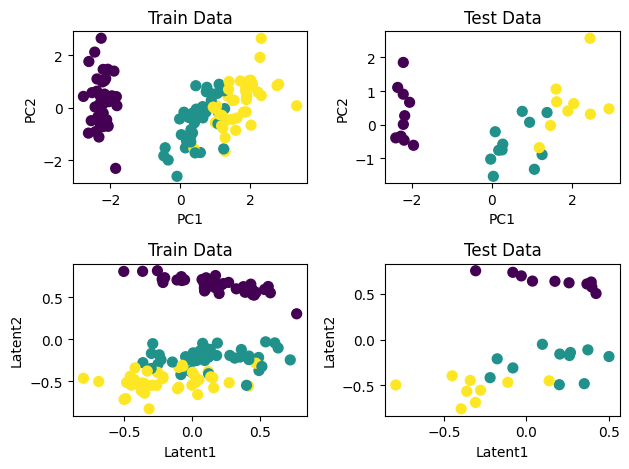

In [20]:
# Scatter plots empleando el último fold

# PCA: PC1 y PC2
fig, ([fig1, fig2], [fig3, fig4]) = plt.subplots(nrows=2,ncols=2)

fig1.scatter(X_PC_train[:,0], X_PC_train[:,1], s=50, c=y_train, marker="o")
fig1.set_xlabel("PC1")
fig1.set_ylabel("PC2")
fig1.set_title("Train Data")
fig2.scatter(X_PC_test[:,0],  X_PC_test[:,1],  s=50, c=y_test, marker="o")
fig2.set_xlabel("PC1")
fig2.set_ylabel("PC2")
fig2.set_title("Test Data")

# Representaciones latentes Auto-Enconder
_, _, _, _ = clf_AE_SVM(X_train, X_test, y_train, y_test, plot=True, ax1=fig3, ax2=fig4)

plt.draw()
plt.tight_layout(pad=1.08)
plt.show()

### **Ejercicio 3: dataset "Leukemia"**

In [21]:
# Carga de datos y preprocesamiento
# Leukemia

data_train = pd.read_csv('http://tsam-fich.wikidot.com/local--files/apuntes/leukemia_train.csv', header=None)
data_test  = pd.read_csv('http://tsam-fich.wikidot.com/local--files/apuntes/leukemia_test.csv', header=None)

# separo patrones en X y etiquetas en Y para train y test
X_train = np.array(data_train)[:,:-1]           # patrones train
y_train = np.ravel(np.array(data_train)[:,-1:]) # etiquetas train
X_test = np.array(data_test)[:,:-1]             # patrones test
y_test = np.ravel(np.array(data_test)[:,-1:])   # etiquetas test

# Estandarización
scaler = StandardScaler()
# Ajuste sobre de train
scaler.fit(X_train)
# transformación de datos train y test
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# defino lista de clasificadores
classifiers = ["clf_NB","clf_MLP","clf_RBF","clf_TREE","clf_RF","clf_SVM","clf_kMeans"]

**Evaluación de desempeño de los clasificadores empleando las 7129 características**

In [22]:
vacc = []
vuar = []
vrec = []
vnf  = []

start_time = time.time()
for clf in range(0,len(classifiers)):
    acc, uar, rec, nf = locals()[classifiers[clf]](X_train, X_test, y_train, y_test)
    vacc.append(acc)
    vuar.append(uar)
    vrec.append(rec)
    vnf.append(nf)

elapsed_time = time.time() - start_time

print(':::          Complete Feature Set             :::')
table = [["Clasificador","Accuracy","UAR", "# Features"]]
for clf in range(0,len(classifiers)):
    table.append([classifiers[clf][4:], '%.4f' % vacc[clf], '%.4f' % vuar[clf], vnf[clf] ])
print(tabulate(table, tablefmt="fancy_grid", stralign="center"))
print("Tiempo Total Clasificadores: ", '%.4f' % elapsed_time)

/home/diego/anaconda3/envs/santiago_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/diego/anaconda3/envs/santiago_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


:::          Complete Feature Set             :::
╒══════════════╤══════════╤════════╤════════════╕
│ Clasificador │ Accuracy │  UAR   │ # Features │
├──────────────┼──────────┼────────┼────────────┤
│      NB      │  0.9118  │ 0.9143 │    7129    │
├──────────────┼──────────┼────────┼────────────┤
│     MLP      │  0.5882  │ 0.5000 │    7129    │
├──────────────┼──────────┼────────┼────────────┤
│     RBF      │  0.5882  │ 0.5000 │    7129    │
├──────────────┼──────────┼────────┼────────────┤
│     TREE     │  0.9118  │ 0.9143 │    7129    │
├──────────────┼──────────┼────────┼────────────┤
│      RF      │  0.7647  │ 0.7143 │    7129    │
├──────────────┼──────────┼────────┼────────────┤
│     SVM      │  0.8235  │ 0.7857 │    7129    │
├──────────────┼──────────┼────────┼────────────┤
│    kMeans    │  0.7941  │ 0.7607 │    7129    │
╘══════════════╧══════════╧════════╧════════════╛
Tiempo Total Clasificadores:  0.8953


**Selección de características mediante método de ranking basado en ANOVA F-value**


In [23]:
# defino el método de ranking con criterio de ANOVA F (f_classif)
FS = SelectKBest(f_classif, k=20)    # definir cuántas características se desean seleccionar

start_time = time.time()
# realizo la selección en base a datos de train
FS = FS.fit(X_train, y_train)
elapsed_time = time.time() - start_time
# aplico la selección en train y test
X_train_new = FS.transform(X_train)
X_test_new  = FS.transform(X_test)

vacc = []
vuar = []
vnf  = []

start_time = time.time()
# Evaluación de clasificadores con las características seleccionadas
for clf in range(0,len(classifiers)):
    acc, uar, _, nf = locals()[classifiers[clf]](X_train_new, X_test_new, y_train, y_test)
    vacc.append(acc)
    vuar.append(uar)
    vnf.append(nf)

elapsed_time_2 = time.time() - start_time

print(':::   K-Best Ranking based on ANOVA F-value   :::')
table = [["Clasificador","Accuracy","UAR", "# Features"]]
for clf in range(0,len(classifiers)):
    table.append([classifiers[clf][4:], '%.4f' % vacc[clf], '%.4f' % vuar[clf],  vnf[clf] ])
print(tabulate(table, tablefmt="fancy_grid", stralign="center"))
print("Tiempo Selección de Características: ", '%.4f' % elapsed_time)
print("Tiempo Total Clasificadores: ", '%.4f' % elapsed_time_2)

:::   K-Best Ranking based on ANOVA F-value   :::
╒══════════════╤══════════╤════════╤════════════╕
│ Clasificador │ Accuracy │  UAR   │ # Features │
├──────────────┼──────────┼────────┼────────────┤
│      NB      │  0.9412  │ 0.9393 │     20     │
├──────────────┼──────────┼────────┼────────────┤
│     MLP      │  0.9412  │ 0.9286 │     20     │
├──────────────┼──────────┼────────┼────────────┤
│     RBF      │  0.8529  │ 0.8643 │     20     │
├──────────────┼──────────┼────────┼────────────┤
│     TREE     │  0.9118  │ 0.9143 │     20     │
├──────────────┼──────────┼────────┼────────────┤
│      RF      │  0.8824  │ 0.8571 │     20     │
├──────────────┼──────────┼────────┼────────────┤
│     SVM      │  0.8529  │ 0.8214 │     20     │
├──────────────┼──────────┼────────┼────────────┤
│    kMeans    │  0.9118  │ 0.8929 │     20     │
╘══════════════╧══════════╧════════╧════════════╛
Tiempo Selección de Características:  0.0047
Tiempo Total Clasificadores:  0.1488


/home/diego/anaconda3/envs/santiago_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/diego/anaconda3/envs/santiago_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


**Selección de características mediante el método Eliminación Recursiva (RFE) empleando SVM lineal**


In [24]:
# Defino método de evaluación
estimator = LinearSVC(random_state=0, tol=1e-5)
# Defino método de búsqueda
FS = RFE(estimator, n_features_to_select=20,       # definir cuántas características se desean seleccionar
         step=1)                                   # definir cuántas características se eliminan en cada iteración

start_time = time.time()
# Selección de características sobre datos de train
FS = FS.fit(X_train, y_train)
elapsed_time = time.time() - start_time
# Aplico selección en train y test
X_train_new = FS.transform(X_train)
X_test_new  = FS.transform(X_test)

vacc = []
vuar = []
vnf  = []

start_time = time.time()
# Evaluación de clasificadores con las características seleccionadas
for clf in range(0,len(classifiers)):
    acc, uar, _, nf = locals()[classifiers[clf]](X_train_new, X_test_new, y_train, y_test)
    vacc.append(acc)
    vuar.append(uar)
    vnf.append(nf)
elapsed_time_2 = time.time() - start_time

print(':::             RFE - linear SVM              :::')
table = [["Clasificador","Accuracy","UAR", "# Features"]]
for clf in range(0,len(classifiers)):
    table.append([classifiers[clf][4:], '%.4f' % vacc[clf], '%.4f' % vuar[clf], vnf[clf] ])
print(tabulate(table, tablefmt="fancy_grid", stralign="center"))
print("Tiempo Selección de Características: ", '%.4f' % elapsed_time)
print("Tiempo Total Clasificadores: ", '%.4f' % elapsed_time_2)

/home/diego/anaconda3/envs/santiago_env/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/diego/anaconda3/envs/santiago_env/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/diego/anaconda3/envs/santiago_env/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/diego/anaconda3/envs/santiago_env/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitl

:::             RFE - linear SVM              :::
╒══════════════╤══════════╤════════╤════════════╕
│ Clasificador │ Accuracy │  UAR   │ # Features │
├──────────────┼──────────┼────────┼────────────┤
│      NB      │  0.8824  │ 0.9000 │     20     │
├──────────────┼──────────┼────────┼────────────┤
│     MLP      │  0.9706  │ 0.9643 │     20     │
├──────────────┼──────────┼────────┼────────────┤
│     RBF      │  0.5882  │ 0.5000 │     20     │
├──────────────┼──────────┼────────┼────────────┤
│     TREE     │  0.9118  │ 0.9143 │     20     │
├──────────────┼──────────┼────────┼────────────┤
│      RF      │  0.8529  │ 0.8321 │     20     │
├──────────────┼──────────┼────────┼────────────┤
│     SVM      │  0.9706  │ 0.9643 │     20     │
├──────────────┼──────────┼────────┼────────────┤
│    kMeans    │  0.9706  │ 0.9643 │     20     │
╘══════════════╧══════════╧════════╧════════════╛
Tiempo Selección de Características:  28.9159
Tiempo Total Clasificadores:  0.1394


/home/diego/anaconda3/envs/santiago_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


**Selección de características mediante el método Relief**


In [25]:
# Selección de características mediante Relief

FS = relief.Relief(n_features=20) # definir cuántas características se desean seleccionar

start_time = time.time()
# Selección de características sobre datos de train
FS = FS.fit(X_train, y_train)
elapsed_time = time.time() - start_time
# Aplico selección en train y test
X_train_new = FS.transform(X_train)
X_test_new  = FS.transform(X_test)

vacc = []
vuar = []
vnf  = []

start_time = time.time()
# Evaluación de clasificadores con las características seleccionadas
for clf in range(0,len(classifiers)):
    acc, uar, _, nf = locals()[classifiers[clf]](X_train_new, X_test_new, y_train, y_test)
    vacc.append(acc)
    vuar.append(uar)
    vnf.append(nf)
elapsed_time_2 = time.time() - start_time

print(':::                  Relief                   :::')
table = [["Clasificador","Accuracy","UAR", "# Features"]]
for clf in range(0,len(classifiers)):
    table.append([classifiers[clf][4:], '%.4f' % vacc[clf], '%.4f' % vuar[clf], vnf[clf] ])
print(tabulate(table, tablefmt="fancy_grid", stralign="center"))
print("Tiempo Selección de Características: ", '%.4f' % elapsed_time)
print("Tiempo Total Clasificadores: ", '%.4f' % elapsed_time_2)

:::                  Relief                   :::
╒══════════════╤══════════╤════════╤════════════╕
│ Clasificador │ Accuracy │  UAR   │ # Features │
├──────────────┼──────────┼────────┼────────────┤
│      NB      │  0.8235  │ 0.8393 │     20     │
├──────────────┼──────────┼────────┼────────────┤
│     MLP      │  0.8529  │ 0.8214 │     20     │
├──────────────┼──────────┼────────┼────────────┤
│     RBF      │  0.8529  │ 0.8429 │     20     │
├──────────────┼──────────┼────────┼────────────┤
│     TREE     │  0.8235  │ 0.7857 │     20     │
├──────────────┼──────────┼────────┼────────────┤
│      RF      │  0.7647  │ 0.7143 │     20     │
├──────────────┼──────────┼────────┼────────────┤
│     SVM      │  0.8529  │ 0.8214 │     20     │
├──────────────┼──────────┼────────┼────────────┤
│    kMeans    │  0.8235  │ 0.7964 │     20     │
╘══════════════╧══════════╧════════╧════════════╛
Tiempo Selección de Características:  0.6380
Tiempo Total Clasificadores:  0.1931


/home/diego/anaconda3/envs/santiago_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/diego/anaconda3/envs/santiago_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
